In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import sys
import json
import glob
import torch

import numpy as np
import pandas as pd

from PIL import Image

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
from matplotlib import pyplot
import seaborn as sns

In [3]:
from optimizers import Adan, Lookahead, AGC

In [25]:
INPUT_DIR = '../kcg-ml-image-pipeline/output/environmental/ranking_v1/'
PMT_PATH = 'data/environmental/prompt.json'

EMB_PATH = 'data/environmental/clip_text_emb.npz'
WEIGHT_DIR = 'weight/021/environmental/clip_text/'

# EMB_PATH = 'data/environmental/clip_vision_emb.npz'
# WEIGHT_DIR = 'weight/021/environmental/clip_vision/'

BATCH_SIZE = 1024

NUM_MODELS = 7

NUM_FEATURES = 512

LR = 1e-3

# load emb

In [5]:
data = np.load(EMB_PATH, allow_pickle=True)

file_paths = data['file_paths']
path_to_index = {file_path.split('_')[0]: i for i, file_path in enumerate(file_paths)}

# load rank data

In [6]:
paths = sorted(glob.glob(os.path.join(INPUT_DIR, 'ranking_data', '*.json')))

rank_pairs = list()
for path in tqdm(paths):
    js = json.load(open(path))
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')
    
    if (file_path_1 not in path_to_index) or (file_path_2 not in path_to_index):
        continue
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/49097 [00:00<?, ?it/s]

# build rank network

In [7]:
import networkx

In [8]:
graph = networkx.DiGraph()

In [9]:
for img_1, img_2, sel_id in rank_pairs:
    if sel_id == 0:
        graph.add_edge(img_2, img_1)
    else:
        graph.add_edge(img_1, img_2)
len(graph.nodes), len(graph.edges)

(30892, 49038)

## check conflicts

In [10]:
cycles = list(networkx.simple_cycles(graph))
len(cycles)

3

## split samples

In [11]:
subgraphs = list(networkx.weakly_connected_components(graph))
len(subgraphs)

320

In [12]:
subgraph = graph.subgraph(subgraphs[0])
len(subgraph.nodes), len(subgraph.edges)

(30212, 48677)

In [13]:
from metis import part_graph

In [14]:
(edgecuts, parts) = part_graph(subgraph, NUM_MODELS, ncuts=1, niter=10)

In [15]:
nodes = np.array(list(subgraph.nodes.keys()))
parts = np.array(parts)

split_nodes = list()
split_edges = list()

for i in range(NUM_MODELS):

    nodes_i = set(nodes[parts == i])

    edges_i = list()
    for node_0, node_1 in subgraph.edges.keys():
        if node_0 not in nodes_i or node_1 not in nodes_i:
            continue
        edges_i.append((node_0, node_1))

    split_nodes.append(nodes_i)
    split_edges.append(edges_i)

In [16]:
list(map(len, split_edges))

[2898, 3026, 2938, 2967, 2800, 3031, 2965]

# build dataset

In [17]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])

In [18]:
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

In [19]:
split_edges = list()
for nodes_i in split_nodes:
    edges_i = ordered_pairs.query('image_1 in @nodes_i and image_2 in @nodes_i')
    split_edges.append(edges_i)

In [22]:
positive_pooler_outputs = data['positive_pooler_outputs']
negative_pooler_outputs = data['negative_pooler_outputs']

# image_embeds = data['image_embeds']

## build feature

In [23]:
def build_feature(index_1, index_2, pooling_method, use_positive=True, use_negative=False):
    
    if pooling_method == 'pooler_outputs':
        pos_features = positive_pooler_outputs
        neg_features = negative_pooler_outputs
    elif pooling_method == 'image_embeds':
        pos_features = image_embeds
    
    results = list()
    if use_positive:
        results.append(np.stack([pos_features[index_1], pos_features[index_2]], axis=-1))
    if use_negative:
        results.append(np.stack([neg_features[index_1], neg_features[index_2]], axis=-1))
        
    if len(results) == 1:
        return results[0]
    else:
        return np.concatenate(results, axis=0)

In [24]:
val_indices = ordered_pairs.index.difference(sum([list(i.index) for i in split_edges], start=[]))

In [26]:
use_positive = True
use_negative = True
pooling_method = 'pooler_outputs'

train_datas = list()
for edges_i in split_edges:
    train_data = list()
    for image_1, image_2 in edges_i.itertuples(index=False, name=None):
        index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
        train_data.append(build_feature(index_1, index_2, pooling_method, use_positive=use_positive, use_negative=use_negative))
    train_datas.append(np.stack(train_data, axis=0))

val_data = list()
for image_1, image_2 in ordered_pairs.loc[val_indices].itertuples(index=False, name=None):
    index_1, index_2 = path_to_index[image_1], path_to_index[image_2]
    val_data.append(build_feature(index_1, index_2, pooling_method, use_positive=use_positive, use_negative=use_negative))
val_data = np.stack(val_data, axis=0)

In [27]:
val_dataset = torch.tensor(val_data).half()#.cuda()

# build model

In [31]:
def train_model(model, train_data, feature_selection=None):
    
    if feature_selection is not None:
        train_data = train_data[..., feature_selection, :]
    train_dataset = torch.tensor(train_data).half().cuda()
    
    model = model.cuda()
    
    parameters = list(model.parameters())

    optimizer = Adan(parameters, lr=LR, weight_decay=1e-2)
    optimizer = Lookahead(optimizer)
    # optimizer = AGC(optimizer)
    
    scaler = torch.cuda.amp.GradScaler()

    for epoch in tqdm(range(500), leave=False):

        bces, accs = list(), list()

        model.train()

        label = torch.zeros((train_dataset.shape[0],), device='cuda')

        x = train_dataset

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(True):

            y0 = model(x[..., 0])
            y1 = model(x[..., 1])

            y = torch.concat([y0, y1], dim=-1)

        # backward

        bce = torch.nn.functional.cross_entropy(y, label.long())

        acc = (y0 > y1).float().mean()

        l1 = torch.norm(model.weight, p=1)

        loss = bce + l1 * 1e-2

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bces.append(bce.detach().cpu().numpy())
        accs.append(acc.detach().cpu().numpy())

    model.eval()

    val_bces, val_accs = list(), list()

    with torch.no_grad():

        with torch.cuda.amp.autocast(True):

            for i in range(0, val_dataset.shape[0], BATCH_SIZE):

                x = val_dataset[i:i+BATCH_SIZE].cuda()
                if feature_selection is not None:
                    x = x[..., feature_selection, :]

                y0 = model(x[..., 0])
                y1 = model(x[..., 1])

                y = torch.concat([y0, y1], dim=-1)

                label = torch.zeros((y.shape[0],), device='cuda').long()

                bce = torch.nn.functional.cross_entropy(y, label)

                acc = (y.argmax(dim=-1) == 0).float().mean()

                val_bces.append(bce.detach().cpu().numpy())
                val_accs.append(acc.detach().cpu().numpy())
    
    print(f'{np.mean(bces):.4f} {np.mean(accs):.4f} {np.mean(val_bces):.4f} {np.mean(val_accs):.4f}')

In [29]:
def inference(models, data, feature_selections=None):
    
    results = list()
    
    for model, feature_selection in zip(models, feature_selections):
        
        model.cuda()
        model.eval()

        ys = list()

        with torch.no_grad():

            with torch.cuda.amp.autocast(True):

                for i in range(0, data.shape[0], BATCH_SIZE):

                    x = data[i:i+BATCH_SIZE].cuda()
                    if feature_selection is not None:
                        x = x[..., feature_selection]

                    y = model(x)

                    ys.append(y.detach().cpu().numpy())
        
        ys = np.concatenate(ys, axis=0)
        results.append(ys)
        
    results = np.concatenate(results, axis=-1)
    
    return results

# train model

In [32]:
models = list()
feature_selections = list()

for i, train_data in enumerate(train_datas):
    
    print(i)
    
    if NUM_FEATURES > 0:
        n_features = NUM_FEATURES
        feature_selection = np.array(sorted(np.random.choice(val_data.shape[1], NUM_FEATURES, False)))
    else:
        n_features = val_data.shape[1]
        feature_selection = None
        
    model = torch.nn.Linear(n_features, 1, bias=True)
    
    model = model.cuda()
    
    train_model(model, train_data, feature_selection)
    
    model = model.cpu()
    
    models.append(model)
    feature_selections.append(feature_selection)

0


  0%|          | 0/2000 [00:00<?, ?it/s]

0.4060 0.8148 0.4472 0.7699
1


  0%|          | 0/2000 [00:00<?, ?it/s]

0.3962 0.8159 0.4428 0.7730
2


  0%|          | 0/2000 [00:00<?, ?it/s]

0.4087 0.8137 0.4487 0.7718
3


  0%|          | 0/2000 [00:00<?, ?it/s]

0.3914 0.8140 0.4447 0.7744
4


  0%|          | 0/2000 [00:00<?, ?it/s]

0.3943 0.8169 0.4469 0.7692
5


  0%|          | 0/2000 [00:00<?, ?it/s]

0.4131 0.8105 0.4541 0.7653
6


  0%|          | 0/2000 [00:00<?, ?it/s]

0.3987 0.8203 0.4482 0.7689


# save model

In [82]:
os.makedirs(WEIGHT_DIR, exist_ok=True)

In [83]:
for i, (model, feature_selection) in enumerate(zip(models, feature_selections)):
    torch.save(model.state_dict(), os.path.join(WEIGHT_DIR, f'{i}.pt'))
    if feature_selection is not None:
        np.save(os.path.join(WEIGHT_DIR, f'{i}.npy'), feature_selection)

# analysis

## val set distribution

In [33]:
x = val_dataset

val_y0 = inference(models, x[..., 0], feature_selections)
val_y1 = inference(models, x[..., 1], feature_selections)

In [34]:
((val_y0 > val_y1).astype(float).mean(axis=-1) > 0.5).mean()

0.7885386617885035

0.7915640610708506


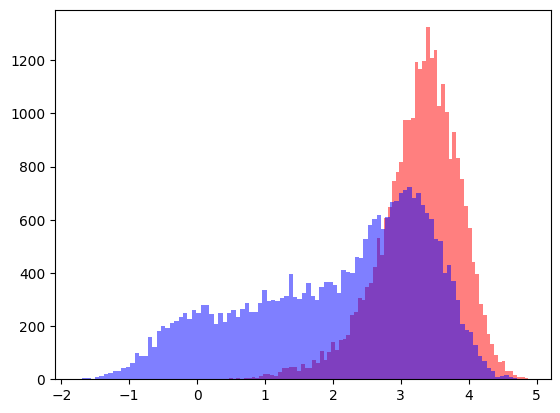

In [35]:
y0, y1 = val_y0.mean(axis=-1), val_y1.mean(axis=-1)

print((y0 > y1).mean())

_ = pyplot.hist(y0, bins=100, color='r', alpha=0.5)
_ = pyplot.hist(y1, bins=100, color='b', alpha=0.5)

## score distribution

In [37]:
# score = inference(models, torch.tensor(image_embeds).half(), feature_selections).astype('float32')
score = inference(models, torch.tensor(np.concatenate([positive_pooler_outputs, negative_pooler_outputs], axis=-1)).half(), feature_selections).astype('float32')

In [38]:
sigma_score = (score - score.mean(axis=0, keepdims=True)) / score.std(axis=0, keepdims=True)

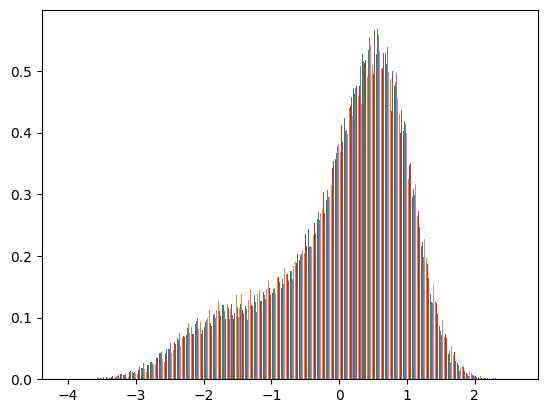

In [39]:
_ = pyplot.hist(sigma_score, bins=100, density=True)
pyplot.show()

In [40]:
sigma_score_mean, sigma_score_std = sigma_score.mean(axis=-1), sigma_score.std(axis=-1)
sigma_score_max, sigma_score_min = sigma_score.max(axis=-1), sigma_score.min(axis=-1)

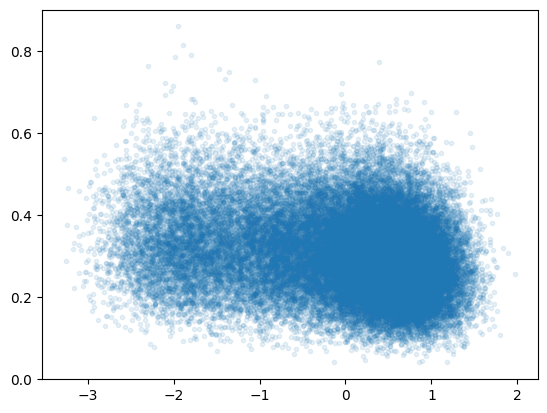

In [41]:
pyplot.plot(sigma_score_mean, sigma_score_std, '.', alpha=0.1)

# save ensemble results

In [42]:
prompts = json.load(open(PMT_PATH))

In [43]:
path_to_hash = {j['file_path'].split('_')[0]:i for i, j in prompts.items()}

In [44]:
results = pd.DataFrame()
results['image_hash'] = [path_to_hash.get(i.split('_')[0]) for i in file_paths]
results['sigma_score_mean'] = sigma_score_mean
results['sigma_score_std'] = sigma_score_std
results['sigma_score_max'] = sigma_score_max
results['sigma_score_min'] = sigma_score_min
results.dropna(inplace=True)

In [45]:
# results.to_csv('./result/2023-11-22-han-ensemble-clip-image-statistics.csv.gz', index=False)
results.to_csv('./result/2023-11-22-han-ensemble-embedding-image-statistics.csv.gz', index=False)

In [49]:
results.query('sigma_score_mean > 1.25 and sigma_score_std > 0.2')

,image_hash,sigma_score_mean,sigma_score_std,sigma_score_max,sigma_score_min
2126,75b723a558e5be39239d0bad6018153ccb08a75b0d0cd0...,1.347757,0.234693,1.658320,0.993624
2155,cb0e5deede233dc5c35f51afc43d57ceaca210729dcca8...,1.415417,0.340676,2.130512,0.950875
2333,89d2024a11093e29b48fb2c883be3ad16d235af71dd0fd...,1.276735,0.378694,1.871106,0.867080
2348,f1396b01a41c67ff96ba7a5061265b2dc4aaca48575193...,1.326633,0.395808,2.120343,0.745050
2425,2ec5cddd938eabe1abbbe1d55e27802729aa9fe2c33c04...,1.685540,0.334730,2.245211,1.292042
...,...,...,...,...,...
45091,5810fe23045f6554e7e5462eb386e597896c310c257d67...,1.557165,0.350314,2.073030,0.883872
45158,a75062e7624bc095e5cea084b48e1d19a866a4bc86dac7...,1.279615,0.376420,1.921776,0.827391
45213,ec1afd14b4a3d77d703b9860e0ec79a612dd8420c22f75...,1.337835,0.245972,1.636516,0.827493
45221,74856cb157618e1644cf72a64c1d59bcfa809b42281256...,1.326571,0.205718,1.734509,1.081266


## prepare for visualization

In [40]:
def select_samples(indices, n_select):
    
    selected = np.random.choice(indices, n_select, False)
    
    selected_file_paths = [file_paths[i] for i in selected]
    selected_file_paths = [i.split('_')[0] + '.jpg' for i in selected_file_paths]
    
    images = np.stack([np.array(Image.open(os.path.join('../kcg-ml-image-pipeline/output/dataset/image/', i))) for i in selected_file_paths])
    images = images.reshape(-1, int(n_select ** 0.5), *images.shape[-3:])
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    
    images = Image.fromarray(images).resize((512, 512))
    
    return selected, images

## show top score samples

In [46]:
threshold = np.quantile(mean, q=0.95)
selected, images = select_samples(np.arange(mean.shape[0])[(mean > threshold) * (std > 0.2)], n_select=9)

threshold

1.5603189766407006

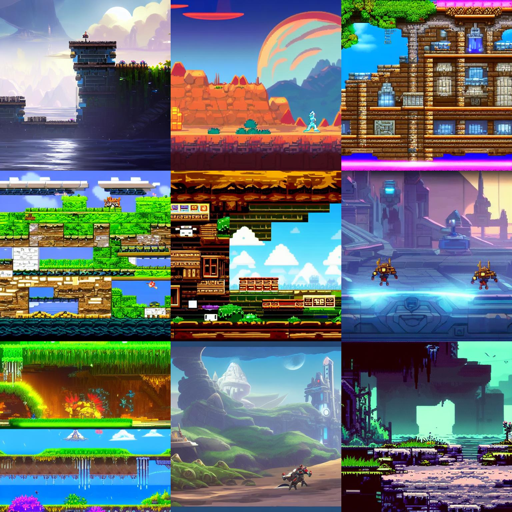

In [47]:
images

## show lowest score samples

In [43]:
threshold = np.quantile(mean, q=0.05)
selected, images = select_samples(np.arange(mean.shape[0])[mean < threshold], n_select=9)

threshold

-1.6097631633281708

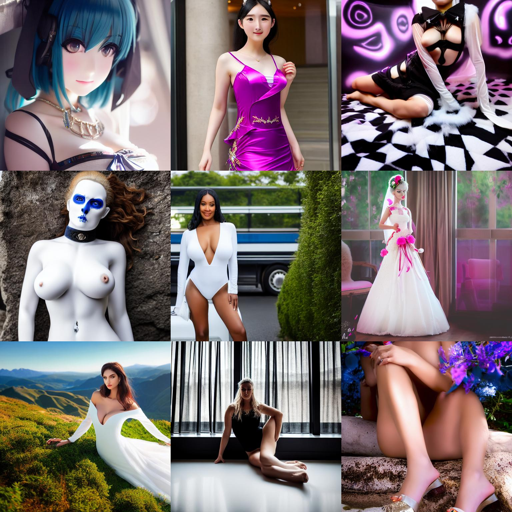

In [44]:
images